PyTorch CNN Image Classifier for CIFAR-10
---
---
```
Step 1: Examine Dataset
Step 2: Split Dataset between Train and Val
Step 3: Create Dataloaders and Move Data to GPU
Step 4: Define Model
Step 5: Set Hyperparameters
Step 6: Train Model
   -Generate Predictions
   -Calculate Loss (Cross Entropy)
   -Compute Gradient (Adam or SGD)
   -Step
   -Reset Gradient to Zero
Step 7: Evaluate Model with Validation Set
Step 8: Decide if Further Training is Necessary
Step 9: Save Weights
```

In [1]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1982.2 MB 2.5 kB/s eta 0:00:011    |████▊                           | 290.2 MB 17.0 MB/s eta 0:01:40     |████▊                           | 291.5 MB 17.0 MB/s eta 0:01:40     |████▊                           | 292.9 MB 17.0 MB/s eta 0:01:40     |████▊                           | 294.3 MB 17.0 MB/s eta 0:01:40     |█████                           | 307.8 MB 17.0 MB/s eta 0:01:39     |████████▎                       | 510.9 MB 18.5 MB/s eta 0:01:20     |████████▎                       | 515.1 MB 18.5 MB/s eta 0:01:20     |████████▌                       | 526.0 MB 28.1 MB/s eta 0:00:52     |█████████▍                      | 579.9 MB 41.7 MB/s eta 0:00:34     |█████████▍                      | 582.6 MB 41.7 MB/s eta 0:00:34     |█████████▌                      | 589.5 MB 41.7 MB/s eta 0:00:34     |█████████████▉                  | 857.0 MB 8.2 MB/s eta 0:02:17     |█████████████▉  

In [2]:
import os
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tt
import torch.nn.functional as F
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# check versions of torch and confirm detected device
print(torch.__version__)
print(torch.cuda.is_available())

1.8.0+cu111
True


In [3]:
# download the CIFAR-10 dataset
download_url("https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz", '.')

# extract images and convert to tensors
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [4]:
# data augmentation to prevent overfitting
train_transform = tt.Compose([tt.RandomCrop(32, padding=8, padding_mode='edge'), 
                         tt.RandomHorizontalFlip(),
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor()])

In [5]:
train_ds = ImageFolder('./data/cifar10/train', transform=train_transform)
test_ds = ImageFolder('./data/cifar10/test', transform=tt.ToTensor())

In [6]:
# set device to cpu or gpu depending on availability
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)

Device:  cuda:0


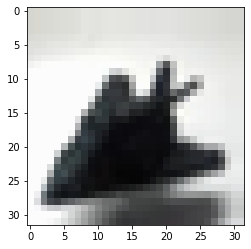

In [7]:
# examine dataset and print an image
img, label = train_ds[0]
plt.imshow(img.permute(1,2,0))

In [8]:
# Hyperparameters
epochs = 10
batch_size = 128
learning_rate = 0.001
#val_size = 5000
workers = 2

'''
# Splitting Dataset to create a Validation Set
torch.manual_seed(40)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
'''

# DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=workers, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True, num_workers=workers, pin_memory=True)

# Design Convolutional Neural Network model
class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

# Instantiate CNN
model = CnnModel().to(device)
# Instantiating Loss Function
criterion = nn.CrossEntropyLoss()
# Instantiating Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Train the model
total_step = len(train_dl)
history = []
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        
        ##FORWARD PASS##
        # Make Prediction using CNN
        yhat = model(images)
        # Calculate Loss using Cross Entropy
        loss = criterion(yhat, labels)
        
        ##BACKPROPAGATION##
        # Calculate Gradient
        loss.backward()
        # Take Step
        optimizer.step()
        # Zero Gradients
        optimizer.zero_grad()
        
        # Print Current State of Model
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.item()))
    history.append(loss.item())

Epoch [1/10], Step [100/391], Loss: 1.7108
Epoch [1/10], Step [200/391], Loss: 1.5132
Epoch [1/10], Step [300/391], Loss: 1.4362
Epoch [2/10], Step [100/391], Loss: 1.0549
Epoch [2/10], Step [200/391], Loss: 1.2150
Epoch [2/10], Step [300/391], Loss: 1.2335
Epoch [3/10], Step [100/391], Loss: 0.9648
Epoch [3/10], Step [200/391], Loss: 0.8460
Epoch [3/10], Step [300/391], Loss: 0.8439
Epoch [4/10], Step [100/391], Loss: 0.7348
Epoch [4/10], Step [200/391], Loss: 0.8836
Epoch [4/10], Step [300/391], Loss: 0.7076
Epoch [5/10], Step [100/391], Loss: 0.9363
Epoch [5/10], Step [200/391], Loss: 0.7013
Epoch [5/10], Step [300/391], Loss: 0.7062
Epoch [6/10], Step [100/391], Loss: 0.7974
Epoch [6/10], Step [200/391], Loss: 0.7013
Epoch [6/10], Step [300/391], Loss: 0.5747
Epoch [7/10], Step [100/391], Loss: 0.6909
Epoch [7/10], Step [200/391], Loss: 0.5944
Epoch [7/10], Step [300/391], Loss: 0.7173
Epoch [8/10], Step [100/391], Loss: 0.7461
Epoch [8/10], Step [200/391], Loss: 0.6841
Epoch [8/10

In [10]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model_ckpt.pth')

Test Accuracy of the model on test images: 79.74 %


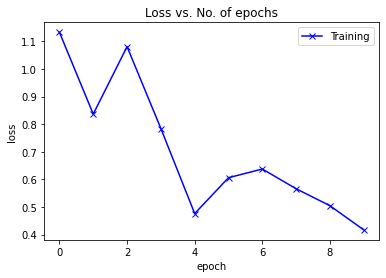

In [11]:
# Plot the model loss as a function of epochs
plt.plot(history, '-bx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training'])
plt.title('Loss vs. No. of epochs');